# Solving the Taxi - Problem with TD(0) Algorithms

### Problem Description (Goal):

Say our agent is the driving the taxi. There are totally four locations and the agent has to pick up a passenger at one location and drop at the another. The agent will receive +20 points as a reward for successful drop off and -1 point for every time step it takes. The agent will also lose -10 points for illegal pickups and drops. So the goal of our agent is to learn to pick up and drop passengers at the correct location in a short time without boarding any illegal passengers.

## 1. Load Libraries & Define OpenAI Gym Environment

In [1]:
import gym
import random
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from collections import defaultdict, OrderedDict

In [2]:
env = gym.make('Taxi-v3')

In [3]:
print('OpenAI Gym environments for Taxi Problem:')
[k for k in gym.envs.registry.env_specs.keys() if k.find('Taxi', 0) >=0]

OpenAI Gym environments for Taxi Problem:


['Taxi-v3']

The **environment** is shown below, where the **letters (R, G, Y, B)** represents the **different locations** and a *tiny yellow colored rectangle* is the **taxi** driving by our agent.

In [4]:
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



For details on the notation followed for state-actions and rewards inside the `"Taxi-v3"` environment:

In [5]:
# Note: this requires a better understanding
tmp = pd.DataFrame.from_dict(env.P[93], orient='index')
tmp = pd.DataFrame(tmp[0].tolist(), index=tmp.index, columns=['A', 'State_no', 'Reward', 'Illegal_Passenger'])
tmp

,A,State_no,Reward,Illegal_Passenger
0,1.0,193,-1,False
1,1.0,93,-1,False
2,1.0,93,-1,False
3,1.0,73,-1,False
4,1.0,93,-10,False
5,1.0,93,-10,False


In [6]:
help(env)

Help on TimeLimit in module gym.wrappers.time_limit object:

class TimeLimit(gym.core.Wrapper)
 |  TimeLimit(env, max_episode_steps=None)
 |  
 |  Wraps the environment to allow a modular transformation.
 |  
 |  This class is the base class for all wrappers. The subclass could override
 |  some methods to change the behavior of the original environment without touching the
 |  original code.
 |  
 |  .. note::
 |  
 |      Don't forget to call ``super().__init__(env)`` if the subclass overrides :meth:`__init__`.
 |  
 |  Method resolution order:
 |      TimeLimit
 |      gym.core.Wrapper
 |      gym.core.Env
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, env, max_episode_steps=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  reset(self, **kwargs)
 |      Resets the environment to an initial state and returns an initial
 |      observation.
 |      
 |      Note that this function should not reset the environment's ra

## 2. RL-Algorithms based on Temporal Difference - TD(0) 

### 2a. Load the "PlotUtils" Python class

Load the Python class `PlotUtils()` which provides various plotting utilities and start a new instance.

In [7]:
%run ../PlotUtils.py

In [8]:
plotutls = PlotUtils()

### 2b. Load the "Temporal Difference" Python class

Load the **Temporal Difference Python class**, `TemporalDifferenceUtils()` and start a new instance for the `Taxi-v3` OpenAI Gym environment.

In [9]:
%run ../TD0_Utils.py 

In [10]:
TD0 = TemporalDifferenceUtils(env)

## 3. Model Training

### 3a. SARSA on-Policy TD(0) Control

**Notes on the RL trials tested below:**
* **discount factor (or gamma):** It is generally inrtrinsic property of the model. Having tried a `gamma= 0.7` for the taxi problem we discuss render our SARSA on-policy solution quite unstable. For this reason we have fixed it at "1" in all the models we are testing below.

<img src="./sarsa_taxi_problem-low_discount.jpg">

Train some candidates **RL-models** of **SARSA on-policy TD(0) Control**:

In [11]:
# Define Number of Episodes
n_episodes = 3e+3

# e-greedy parameters to investigate
print('Determine the epsilon parameters for the epsilon-greedy policy...\n')
epsilons = np.arange(0.01, 0.05, 0.01)
print('epsilons: {}'.format(epsilons), '\n')

# various step-sizes (alpha) to try
print('Determine the step-sizes parameters (alphas) for the TD(0)...\n')
step_sizes = np.array(0.4)
print('step_sizes: {}'.format(step_sizes), '\n')

# Fixed discount
discount_fixed = 1

# Create a mesh-grid of trials
print('Create a dictionary of the RL-models of interest...\n')
epsilons, step_sizes = np.meshgrid(epsilons, step_sizes)

# Create a dictionary of the RL-trials of interest
RL_trials = {"baseline":
             {'epsilon': 0.017,
              'step_size': 0.4, 'discount': 1}}

for n, trial in enumerate(list(zip(*epsilons, *step_sizes))):
    key = 'trial_' + str(n+1)
    RL_trials[key] = {'epsilon': trial[0], 
                      'step_size': trial[1], 'discount': discount_fixed}
print('Number of RL-models to try: {}\n'.format(len(RL_trials)))

print('Let all RL-models to be trained for {0:,} episodes...\n'.format(int(n_episodes)))

rewards_per_trial_SARSA = OrderedDict((label, np.array([])) for label, _ in RL_trials.items())
q_values_per_trial_SARSA = OrderedDict((label, np.array([])) for label, _ in RL_trials.items())

for trial, params_dict in RL_trials.items():
    
    # Read out parameters from "params_dict"
    epsilon = params_dict['epsilon']
    step_size = params_dict['step_size']
    discount = params_dict['discount']
    
    # Apply SARSA [on-policy TD(0) Control]
    q_values, tot_rewards = TD0.sarsa_on_policy_control(env, n_episodes=n_episodes, 
                                                        step_size=step_size, discount=discount, epsilon=epsilon)
    
    # Update "rewards_per_trial" and "q_values_per_trial" OrderedDicts
    rewards_per_trial_SARSA[trial] = tot_rewards
    q_values_per_trial_SARSA[trial] = q_values

Determine the epsilon parameters for the epsilon-greedy policy...

epsilons: [0.01 0.02 0.03 0.04] 

Determine the step-sizes parameters (alphas) for the TD(0)...

step_sizes: 0.4 

Create a dictionary of the RL-models of interest...

Number of RL-models to try: 5

Let all RL-models to be trained for 3,000 episodes...



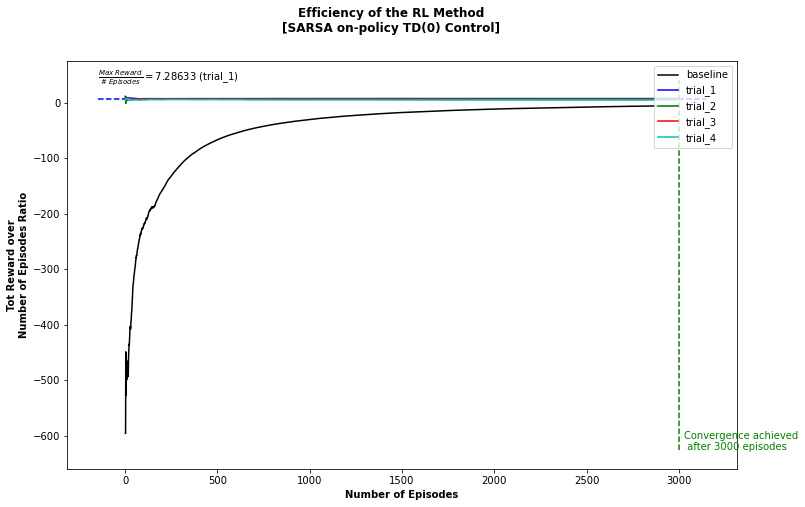

In [12]:
title = 'Efficiency of the RL Method\n[SARSA on-policy TD(0) Control]'
plotutls.plot_learning_curve(rewards_per_trial_SARSA, title=title)

It turns out that the best one is the so-called `"trial_1"`:

In [13]:
RL_trials['trial_1']

{'epsilon': 0.01, 'step_size': 0.4, 'discount': 1}

In [14]:
RL_trials

{'baseline': {'epsilon': 0.017, 'step_size': 0.4, 'discount': 1},
 'trial_1': {'epsilon': 0.01, 'step_size': 0.4, 'discount': 1},
 'trial_2': {'epsilon': 0.02, 'step_size': 0.4, 'discount': 1},
 'trial_3': {'epsilon': 0.03, 'step_size': 0.4, 'discount': 1},
 'trial_4': {'epsilon': 0.04, 'step_size': 0.4, 'discount': 1}}

### 3b. Q-Learning Off-Policy TD(0) Control

In [15]:
# Define Number of Episodes
n_episodes = 3e+3

# e-greedy parameters to investigate
print('Determine the epsilon parameters for the epsilon-greedy policy...\n')
epsilons = np.arange(0.01, 0.05, 0.01)
print('epsilons: {}'.format(epsilons), '\n')

# various step-sizes (alpha) to try
print('Determine the step-sizes parameters (alphas) for the TD(0)...\n')
step_sizes = np.array(0.4)
print('step_sizes: {}'.format(step_sizes), '\n')

# Fixed discount
discount_fixed = 1

# Create a mesh-grid of trials
print('Create a dictionary of the RL-models of interest...\n')
epsilons, step_sizes = np.meshgrid(epsilons, step_sizes)

# Create a dictionary of the RL-trials of interest
RL_trials = {"baseline":
             {'epsilon': 0.017,
              'step_size': 0.4, 'discount': 1}}

for n, trial in enumerate(list(zip(*epsilons, *step_sizes))):
    key = 'trial_' + str(n+1)
    RL_trials[key] = {'epsilon': trial[0], 
                      'step_size': trial[1], 'discount': discount_fixed}
print('Number of RL-models to try: {}\n'.format(len(RL_trials)))

print('Let all RL-models to be trained for {0:,} episodes...\n'.format(int(n_episodes)))

rewards_per_trial_QL = OrderedDict((label, np.array([])) for label, _ in RL_trials.items())
q_values_per_trial_QL = OrderedDict((label, np.array([])) for label, _ in RL_trials.items())

for trial, params_dict in RL_trials.items():
    
    # Read out parameters from "params_dict"
    epsilon = params_dict['epsilon']
    step_size = params_dict['step_size']
    discount = params_dict['discount']
    
    # Apply SARSA [on-policy TD(0) Control]
    q_values, tot_rewards = TD0.q_learning_off_policy(env, n_episodes=n_episodes, 
                                                      step_size=step_size, discount=discount, epsilon=epsilon)
    
    # Update "rewards_per_trial" and "q_values_per_trial" OrderedDicts
    rewards_per_trial_QL[trial] = tot_rewards
    q_values_per_trial_QL[trial] = q_values

Determine the epsilon parameters for the epsilon-greedy policy...

epsilons: [0.01 0.02 0.03 0.04] 

Determine the step-sizes parameters (alphas) for the TD(0)...

step_sizes: 0.4 

Create a dictionary of the RL-models of interest...

Number of RL-models to try: 5

Let all RL-models to be trained for 3,000 episodes...



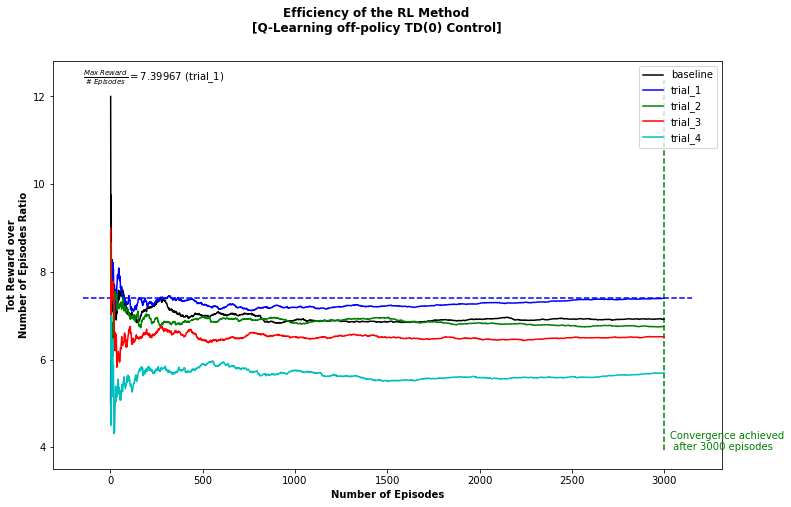

In [16]:
title = 'Efficiency of the RL Method\n[Q-Learning off-policy TD(0) Control]'
plotutls.plot_learning_curve(rewards_per_trial_QL, title=title)

Again, the best RL-model was the so-called `"trial_1"`:

In [17]:
RL_trials['trial_1']

{'epsilon': 0.01, 'step_size': 0.4, 'discount': 1}

In [18]:
RL_trials

{'baseline': {'epsilon': 0.017, 'step_size': 0.4, 'discount': 1},
 'trial_1': {'epsilon': 0.01, 'step_size': 0.4, 'discount': 1},
 'trial_2': {'epsilon': 0.02, 'step_size': 0.4, 'discount': 1},
 'trial_3': {'epsilon': 0.03, 'step_size': 0.4, 'discount': 1},
 'trial_4': {'epsilon': 0.04, 'step_size': 0.4, 'discount': 1}}

### 3c. On-Policy Expected SARSA

In [19]:
# Define Number of Episodes
n_episodes = 3e+3

# e-greedy parameters to investigate
print('Determine the epsilon parameters for the epsilon-greedy policy...\n')
epsilons = np.arange(0.01, 0.05, 0.01)
print('epsilons: {}'.format(epsilons), '\n')

# various step-sizes (alpha) to try
print('Determine the step-sizes parameters (alphas) for the TD(0)...\n')
step_sizes = np.array(0.4)
print('step_sizes: {}'.format(step_sizes), '\n')

# Fixed discount
discount_fixed = 1

# Create a mesh-grid of trials
print('Create a dictionary of the RL-models of interest...\n')
epsilons, step_sizes = np.meshgrid(epsilons, step_sizes)

# Create a dictionary of the RL-trials of interest
RL_trials = {"baseline":
             {'epsilon': 0.017,
              'step_size': 0.4, 'discount': 1}}

for n, trial in enumerate(list(zip(*epsilons, *step_sizes))):
    key = 'trial_' + str(n+1)
    RL_trials[key] = {'epsilon': trial[0], 
                      'step_size': trial[1], 'discount': discount_fixed}
print('Number of RL-models to try: {}\n'.format(len(RL_trials)))

print('Let all RL-models to be trained for {0:,} episodes...\n'.format(int(n_episodes)))

rewards_per_trial_ExpSARSA = OrderedDict((label, np.array([])) for label, _ in RL_trials.items())
q_values_per_trial_ExpSARSA = OrderedDict((label, np.array([])) for label, _ in RL_trials.items())

for trial, params_dict in RL_trials.items():
    
    # Read out parameters from "params_dict"
    epsilon = params_dict['epsilon']
    step_size = params_dict['step_size']
    discount = params_dict['discount']
    
    # Apply SARSA [on-policy TD(0) Control]
    q_values, tot_rewards = TD0.expected_sarsa_on_policy(env, n_episodes=n_episodes, 
                                                         step_size=step_size, discount=discount, epsilon=epsilon)
    
    # Update "rewards_per_trial" and "q_values_per_trial" OrderedDicts
    rewards_per_trial_ExpSARSA[trial] = tot_rewards
    q_values_per_trial_ExpSARSA[trial] = q_values

Determine the epsilon parameters for the epsilon-greedy policy...

epsilons: [0.01 0.02 0.03 0.04] 

Determine the step-sizes parameters (alphas) for the TD(0)...

step_sizes: 0.4 

Create a dictionary of the RL-models of interest...

Number of RL-models to try: 5

Let all RL-models to be trained for 3,000 episodes...



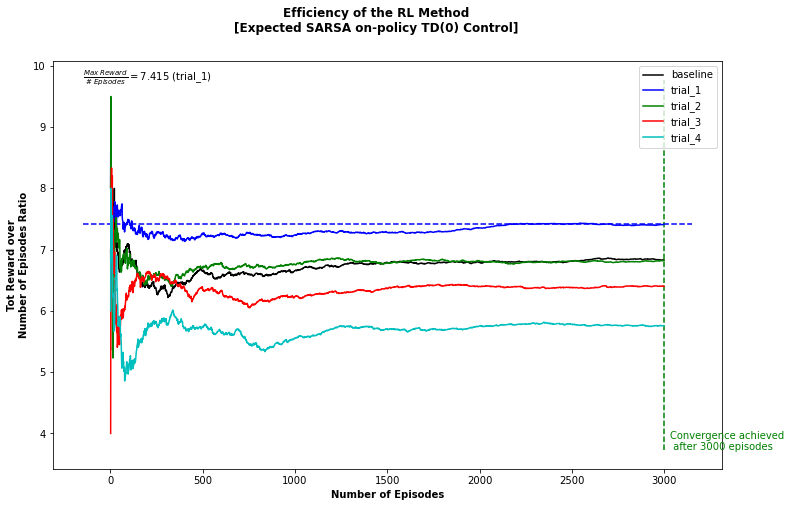

In [20]:
title = 'Efficiency of the RL Method\n[Expected SARSA on-policy TD(0) Control]'
plotutls.plot_learning_curve(rewards_per_trial_ExpSARSA, title=title)

Again, the best RL-model was the so-called `"trial_1"`:

In [21]:
RL_trials['trial_1']

{'epsilon': 0.01, 'step_size': 0.4, 'discount': 1}

In [22]:
RL_trials

{'baseline': {'epsilon': 0.017, 'step_size': 0.4, 'discount': 1},
 'trial_1': {'epsilon': 0.01, 'step_size': 0.4, 'discount': 1},
 'trial_2': {'epsilon': 0.02, 'step_size': 0.4, 'discount': 1},
 'trial_3': {'epsilon': 0.03, 'step_size': 0.4, 'discount': 1},
 'trial_4': {'epsilon': 0.04, 'step_size': 0.4, 'discount': 1}}

## 4. Comparison of SARSA, Q-Learning and Expected SARSA best models

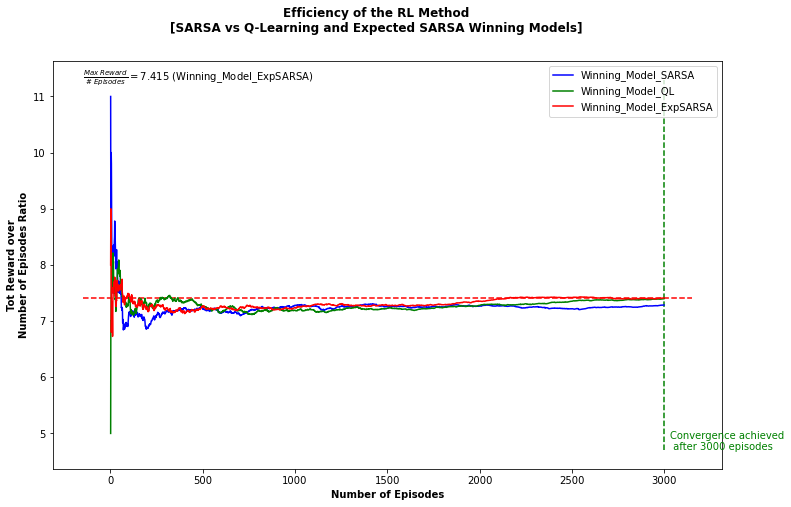

In [23]:
rewards_per_trial_best_models = OrderedDict([('Winning_Model_SARSA', np.array([])), 
                                             ('Winning_Model_QL', np.array([])),
                                             ('Winning_Model_ExpSARSA', np.array([]))])

rewards_per_trial_best_models['Winning_Model_SARSA'] = rewards_per_trial_SARSA['trial_1']
rewards_per_trial_best_models['Winning_Model_QL'] = rewards_per_trial_QL['trial_1']
rewards_per_trial_best_models['Winning_Model_ExpSARSA'] = rewards_per_trial_ExpSARSA['trial_1']

title = 'Efficiency of the RL Method\n[SARSA vs Q-Learning and Expected SARSA Winning Models]'
plotutls.plot_learning_curve(rewards_per_trial_best_models, title=title)